In [ ]:
import torch

### Rotation Angles for RoPE
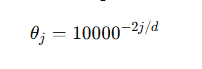

In [24]:
def compute_rope_frequencies(seq_len, dim, base = 1000):
  half_dim = dim // 2 # We apply rope to only half the sequence
  exponents = torch.arange(half_dim, dtype = torch.float32) / half_dim
  theta = base ** -exponents
  return theta

### Computing sine and cos values for rotation

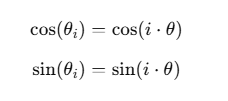

In [25]:
def compute_rope_cache(seq_len, dim):
  theta = compute_rope_frequencies(seq_len, dim)
  positions = torch.arange(seq_len, dtype = torch.float32).unsqueeze(1) # (seq_len, 1)

  angles = positions * theta.unsqueeze(0) # (seq_len, half_dim)
  cos_values = torch.cos(angles) # (seq_len, half_dim)
  sin_values = torch.sin(angles) # (seq_len,half_dim)
  return cos_values, sin_values

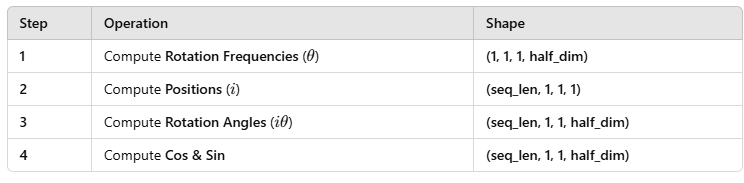

### Performing the negation swap

Split the tensor into 2 parts, swap the 2 parts while negating the second part

### Applying RoPE

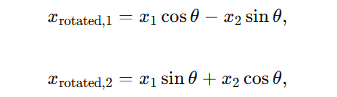

In [26]:
def apply_rope(x, cos, sin):
    x1, x2 = x.chunk(2, dim = -1) # Each have dimension head_dim / 2

    cos = cos.unsqueeze(0).unsqueeze(0) # (seq_lin, half_dim) --> (seq_len, 1, 1, half_dim)
    sin = sin.unsqueeze(0).unsqueeze(0) # (seq_lin, half_dim) --> (seq_len, 1, 1, half_dim)

    x_rotated_1 = x1 * cos + x2 * sin
    x_rotated_2 = x1 * -sin + x2 * cos

    return torch.cat((x_rotated_1, x_rotated_2), dim = -1)

def rope_embedding(Q, K, cos, sin):
    Q_rope = apply_rope(Q, cos, sin)
    K_rope = apply_rope(K, cos, sin)
    return Q_rope, K_rope

In [27]:
batch_size, seq_len, n_heads, head_dim = 2, 128, 8, 64
Q = torch.randn(batch_size, n_heads, seq_len, head_dim)
K = torch.randn(batch_size, n_heads, seq_len, head_dim)

cos_cache, sin_cache = compute_rope_cache(seq_len, head_dim)
Q_rope, K_rope = rope_embedding(Q, K, cos_cache, sin_cache)

print("Q_rope shape:", Q_rope.shape)
print("K_rope shape:", K_rope.shape)

Q_rope shape: torch.Size([2, 8, 128, 64])
K_rope shape: torch.Size([2, 8, 128, 64])


In [40]:
class RoPE:
    def __init__(self, seq_len, head_dim):
        self.cos_cache, self.sin_cache = compute_rope_cache(seq_len, head_dim)

    def compute_rope_frequencies(self, seq_len, head_dim, base = 1000):
        half_dim = head_dim //2
        exponent = torch.arange(half_dim, dtype = torch.float32)/ half_dim
        theta = base ** (-exponent)

    def compute_rope_cache(self, seq_len, head_dim):
        theta = compute_rope_frequencies(seq_len, head_dim)

        sequence = torch.arange(self, seq_len, dtype = torch.float32)
        angles = sequence * theta.unsqueeze(0) # (seq_len,) * (1,half_dim) --> (seq_len, half_dim)
        cos_cache = torch.cos(angles)
        sin_cache = torch.sin(angles)

        return cos_cache, sin_cache

    def apply_rope(self, x):
        x1, x2 = x.chunk(2, dim = -1)
        cos, sin = self.cos_cache, self.sin_cache

        cos = cos.unsqueeze(1).unsqueeze(1) # (seq_len, half_dim) --> (seq_len, 1, 1, half_dim)
        sin = sin.unsqueeze(1).unsqueeze(1) # (seq_len, half_dim) --> (seq_len, 1,1,half_dim)

        x_rotated_1 = x1 * cos + x2 * sin
        x_rotated_2 = x1 * -sin + x2 * cos

        return torch.cat((x_rotated_1, x_rotated_2), dim = -1)

    def rope_embedding(self,Q, K):
        Q_rope = self.apply_rope(Q)
        K_rope = self.apply_rope(K)
        return Q_rope, K_rope

In [41]:
batch_size, seq_len, n_heads, head_dim = 2, 128, 8, 64
Q = torch.randn(seq_len, batch_size, n_heads, head_dim)
K = torch.randn(seq_len, batch_size, n_heads, head_dim)

In [44]:
rope = RoPE(seq_len, head_dim)
Q_rope, K_rope = rope.rope_embedding(Q, K)

In [45]:
print("Q_rope shape:", Q_rope.shape)
print("K_rope shape:", K_rope.shape)

Q_rope shape: torch.Size([128, 2, 8, 64])
K_rope shape: torch.Size([128, 2, 8, 64])
